<a href="https://colab.research.google.com/github/venkateshakula1729/BSE662-Course-Project-Foraging-Based/blob/master/MNE%20python%20group/Forging_Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Install MNE version 1.8
!pip install mne==1.8.0


In [9]:
# Import required libraries
import mne
import matplotlib.pyplot as plt
import numpy as np

In [10]:
!pip install pymatreader

Loading 31730.set ...
<Info | 8 non-empty values
 bads: []
 ch_names: T4, A2, C3, C4, A1, T3, O1, T5, O2, F8, T6, FZ, FP2, F7, FP1, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>
Loading 43000.set ...
<Info | 8 non-empty values
 bads: []
 ch_names: T4, A2, C3, C4, A1, T3, O1, T5, O2, F8, T6, FZ, FP2, F7, FP1, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>
Loading 47131.set ...
<Info | 8 non-empty values
 bads: []
 ch_names: T4, A2, C3, C4, A1, T3, O1, T5, O2, F8, T6, FZ, FP2, F7, FP1, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
>
Loading 47204.set ...
<Info | 8 non-empty values
 bads: []

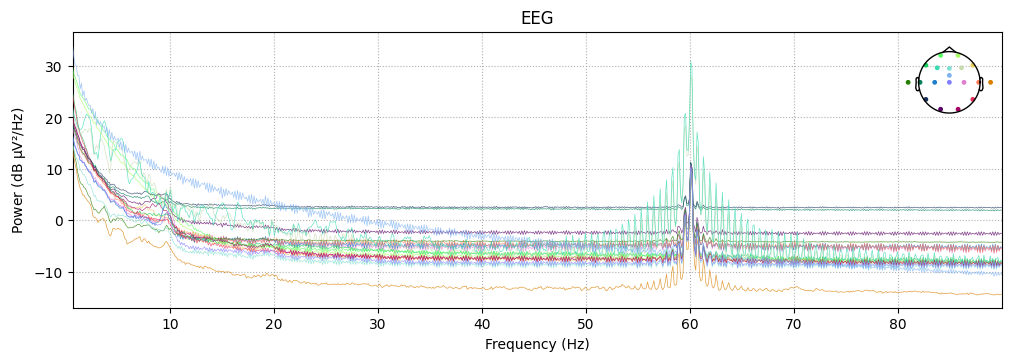

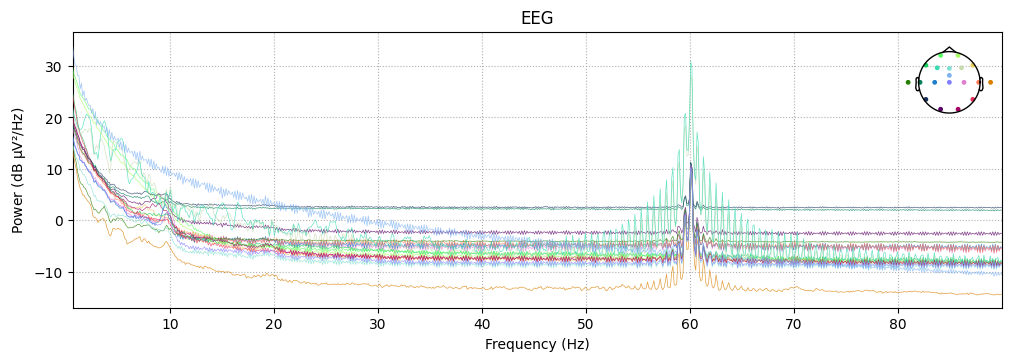

In [11]:

# Define the list of set files
set_files = ['31730.set', '43000.set', '47131.set', '47204.set', '47324.set', '48238.set']

# Load each .set file into an MNE Raw object
raw_list = []
for fname in set_files:
    print(f"Loading {fname} ...")
    raw = mne.io.read_raw_eeglab(fname, preload=True)
    # test
    print(raw.info)
    raw_list.append(raw)

# For demonstration, we will process the first file in the list
raw = raw_list[1]

# -------------------------------
# STEP 1: Plot PSD of the raw data
# -------------------------------
print("Plotting PSD of the raw data...")
raw.plot_psd(fmin=0.5, fmax=90, show=True)




In [12]:

# -------------------------------
# STEP 2: Clean the data
#   2.1. Since line noise is known to be 60 Hz in America, we directly apply a notch filter.
# -------------------------------
print("Applying notch filter at 60 Hz to remove line noise...")
raw_clean = raw.copy().notch_filter(freqs=[60], verbose=False)


# -------------------------------
#   2.2. We apply a bandpass filter between 0.5 and 90 Hz.
# -------------------------------
print("Applying bandpass filter (0.5 - 90 Hz) on the cleaned data...")
raw_clean.filter(l_freq=0.5, h_freq=90, verbose=False)



Applying notch filter at 60 Hz to remove line noise...
Applying bandpass filter (0.5 - 90 Hz) on the cleaned data...


<RawEEGLAB | 43000.set, 19 x 1262750 (5051.0 s), ~183.1 MB, data loaded>

Plotting PSD of the cleaned data...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


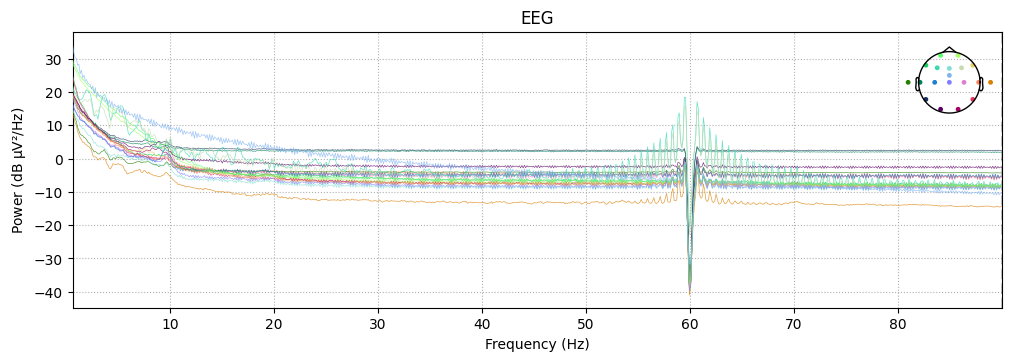

In [13]:

# -------------------------------
# STEP 3: Plot the PSD of the cleaned data
# -------------------------------
print("Plotting PSD of the cleaned data...")
raw_clean.plot_psd(fmin=0.5, fmax=90, show=True)

plt.show()

In [14]:

# -------------------------------
# STEP 3: Marker Extraction
# -------------------------------

print("Extracting event markers from annotations...")

# We try to retrieve annotations from the cleaned raw data
annotations = raw_clean.annotations
print("Annotations:")
print(annotations)

# We assume that each annotation's description has a format like "TRIGGER EVENT X".
unique_markers = set(desc.split()[-1].strip() for desc in annotations.description)
print("Unique marker letters extracted:", unique_markers)

# We initialize a dictionary to count trials for each condition:
# - 'pre_short' and 'pre_long' for prestress conditions;
# - 'post_short' and 'post_long' for poststress conditions.
trial_counts = {"pre_short": 0, "pre_long": 0, "post_short": 0, "post_long": 0}

# We use a variable to keep track of the current stress condition based on block markers.
current_block = None

# Loop over all annotations in time order.
# Marker codes (as expected) are:
#   B: Start of prestress block
#   I: Start of poststress block
#   T: Travel time ~5s   -> short environment trial
#   U: Travel time ~20s  -> long environment trial

for onset, desc in zip(annotations.onset, annotations.description):
    # We will extract the marker letter from the annotation by taking the last token.
    marker = desc.split()[-1].strip()

    if marker == 'B':
        current_block = 'pre'
    elif marker == 'I':
        current_block = 'post'
    # Only count travel time markers if we have a valid current block
    elif marker in ['T', 'U'] and current_block is not None:
        if marker == 'T':
            trial_counts[f"{current_block}_short"] += 1
        elif marker == 'U':
            trial_counts[f"{current_block}_long"] += 1

print("Trial counts per environment:")
print(trial_counts)

Extracting event markers from annotations...
Annotations:
<Annotations | 989 segments: TRIGGER EVENT A (1), TRIGGER EVENT B (1), ...>
Unique marker letters extracted: {'S', 'A', 'E', 'F', 'I', 'N', 'O', 'P', 'G', 'U', 'Z', 'T', 'D', 'C', 'M', 'Q', 'H', 'B', 'R', 'J'}
Trial counts per environment:
{'pre_short': 42, 'pre_long': 39, 'post_short': 44, 'post_long': 39}


## **Epoching and Stimulus Locking for one .set file**

In [18]:
# Extract events and event IDs
events, event_id = mne.events_from_annotations(raw)
print("Extracted Events:", events)  # Check the event markers
print("Event IDs:", event_id)       # Check event labels



Used Annotations descriptions: [np.str_('TRIGGER EVENT A'), np.str_('TRIGGER EVENT B'), np.str_('TRIGGER EVENT C'), np.str_('TRIGGER EVENT D'), np.str_('TRIGGER EVENT E'), np.str_('TRIGGER EVENT F'), np.str_('TRIGGER EVENT G'), np.str_('TRIGGER EVENT H'), np.str_('TRIGGER EVENT I'), np.str_('TRIGGER EVENT J'), np.str_('TRIGGER EVENT M'), np.str_('TRIGGER EVENT N'), np.str_('TRIGGER EVENT O'), np.str_('TRIGGER EVENT P'), np.str_('TRIGGER EVENT Q'), np.str_('TRIGGER EVENT R'), np.str_('TRIGGER EVENT S'), np.str_('TRIGGER EVENT T'), np.str_('TRIGGER EVENT U'), np.str_('TRIGGER EVENT Z')]
Extracted Events: [[  36605       0       1]
 [ 156264       0      20]
 [ 210990       0       2]
 ...
 [1139689       0      20]
 [1141897       0      10]
 [1216727       0      20]]
Event IDs: {np.str_('TRIGGER EVENT A'): 1, np.str_('TRIGGER EVENT B'): 2, np.str_('TRIGGER EVENT C'): 3, np.str_('TRIGGER EVENT D'): 4, np.str_('TRIGGER EVENT E'): 5, np.str_('TRIGGER EVENT F'): 6, np.str_('TRIGGER EVENT G

**Modifying Event ID Dictionary**

In [20]:
event_id = {
    'TRIGGER EVENT A': 1,
    'TRIGGER EVENT B': 2,
    'TRIGGER EVENT C': 3,
    'TRIGGER EVENT D': 4,
    'TRIGGER EVENT E': 5,
    'TRIGGER EVENT F': 6,
    'TRIGGER EVENT G': 7,
    'TRIGGER EVENT H': 8,
    'TRIGGER EVENT I': 9,
    'TRIGGER EVENT J': 10,
    'TRIGGER EVENT M': 11,
    'TRIGGER EVENT N': 12,
    'TRIGGER EVENT O': 13,
    'TRIGGER EVENT P': 14,
    'TRIGGER EVENT Q': 15,
    'TRIGGER EVENT R': 16,
    'TRIGGER EVENT S': 17,
    'TRIGGER EVENT T': 18,
    'TRIGGER EVENT U': 19,
    'TRIGGER EVENT Z': 20
}


In [21]:
# Extract Events Using Annotations
# Convert annotations to events
events, event_id = mne.events_from_annotations(raw, event_id=event_id)

# Print events and event IDs
print("Extracted Events:\n", events)
print("Event IDs:\n", event_id)

Used Annotations descriptions: [np.str_('TRIGGER EVENT A'), np.str_('TRIGGER EVENT B'), np.str_('TRIGGER EVENT C'), np.str_('TRIGGER EVENT D'), np.str_('TRIGGER EVENT E'), np.str_('TRIGGER EVENT F'), np.str_('TRIGGER EVENT G'), np.str_('TRIGGER EVENT H'), np.str_('TRIGGER EVENT I'), np.str_('TRIGGER EVENT J'), np.str_('TRIGGER EVENT M'), np.str_('TRIGGER EVENT N'), np.str_('TRIGGER EVENT O'), np.str_('TRIGGER EVENT P'), np.str_('TRIGGER EVENT Q'), np.str_('TRIGGER EVENT R'), np.str_('TRIGGER EVENT S'), np.str_('TRIGGER EVENT T'), np.str_('TRIGGER EVENT U'), np.str_('TRIGGER EVENT Z')]
Extracted Events:
 [[  36605       0       1]
 [ 156264       0      20]
 [ 210990       0       2]
 ...
 [1139689       0      20]
 [1141897       0      10]
 [1216727       0      20]]
Event IDs:
 {np.str_('TRIGGER EVENT A'): 1, np.str_('TRIGGER EVENT B'): 2, np.str_('TRIGGER EVENT C'): 3, np.str_('TRIGGER EVENT D'): 4, np.str_('TRIGGER EVENT E'): 5, np.str_('TRIGGER EVENT F'): 6, np.str_('TRIGGER EVENT

In [22]:
# Define epoching time window (parameters)
tmin = -1   # tmin: Start time relative to stimulus (e.g., -1s before).
tmax = 2    # tmax: End time relative to stimulus (e.g., 2s after).
baseline = (None, 0)  # baseline: Baseline correction period (e.g., pre-stimulus period).

# Create epochs
epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=baseline, preload=True)

# Save epochs
epochs.save("epochs-epo.fif", overwrite=True)


Not setting metadata
989 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 989 events and 751 original time points ...
0 bad epochs dropped


In [23]:
# Load epoched data
epochs = mne.read_epochs("epochs-epo.fif", preload=True)

# Print basic info
print(epochs)

Reading /content/epochs-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
989 matching events found
No baseline correction applied
0 projection items activated
<EpochsFIF | 989 events (all good), -1 – 2 s (baseline -1 – 0 s), ~107.7 MB, data loaded,
 'TRIGGER EVENT A': 1
 'TRIGGER EVENT B': 1
 'TRIGGER EVENT C': 1
 'TRIGGER EVENT D': 1
 'TRIGGER EVENT E': 1
 'TRIGGER EVENT F': 1
 'TRIGGER EVENT G': 1
 'TRIGGER EVENT H': 1
 'TRIGGER EVENT I': 1
 'TRIGGER EVENT J': 1
 and 10 more events ...>
